In [1]:
using Revise
using LinearAlgebra
using Statistics
using ConstrainedSystems
using CartesianGrids
using ImmersedLayers
using LinearMaps
using IterativeSolvers
using Test

import Base: *

In [2]:
using CairoMakie
using LaTeXStrings

In this notebook, we are interested in solving a Darcy's flow:\

$\nabla \cdot (\kappa^+(x) \nabla \varphi^+) = f^+(x)$ and\
$\nabla \cdot (\kappa^+(x) \nabla \varphi^-) = f^-(x),$\
where $\kappa^+, \kappa^-$ denotes a permeability field on its respective region. 
with Dirichlet boundary conditions $\varphi^+ = \varphi^+_b$ and $\varphi^- = \varphi^-_b$ on $\chi(x) = 0$ 

For $\kappa^+(x) = \kappa^-(x) = 1$, we recover a Poisson problem with Dirichlet boundary conditions

In the rest of this notebook, $+$, $-$ denotes the exterior, interior region of the body, respectively.

Using the formalism of immersed layers described in (Eldredge, 2021,  JCP), we obtain the saddle-point problem for the masked field $\overline{\varphi}$ with Lagrange multiplier $\sigma$ given by the normal jump of $\kappa \nabla \varphi$:

$\begin{bmatrix}
    L & \; \delta(\chi)\\
    \delta^\top(\chi) & \; 0
    \end{bmatrix} \begin{bmatrix} \overline{\varphi} \\
    -\sigma \end{bmatrix} = \begin{bmatrix} \overline{f} + \nabla \cdot ((\kappa_b^+ \varphi^+_b - \kappa_b^- \varphi^-_b) \delta(\chi) \mathbf{n}) \\
   \frac{1}{2}(\varphi_b^+ + \varphi_b^-) \end{bmatrix},$
   where $L \psi = \nabla \cdot(\overline{\kappa} \nabla \psi)$ and $\sigma = \mathbf{n} \cdot (\kappa^+ \nabla \varphi^+ - \kappa^- \nabla \varphi^-)$

In [13]:
Δx = 0.01
Lx = 4
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx)

a = 1.0
b = 1.0
k = 1.5
body = Rectangle(a,b,k*Δx)

cache = SurfaceScalarCache(body,g,scaling=GridScaling);

In [14]:
@ilmproblem DirichletDarcy scalar

In [15]:
struct DirichletDarcyCache{SMT,CMT,FRT,ST,FT} <: ImmersedLayers.AbstractExtraILMCache
    S :: SMT
    C :: CMT
    forcing_cache :: FRT
    fb :: ST
    fstar :: FT
end

In [16]:
function ImmersedLayers.prob_cache(prob::DirichletDarcyProblem,base_cache::BasicILMCache)
    S = create_RTLinvR(base_cache)
    C = create_surface_filter(base_cache)
    forcing_cache = nothing
    fb = zeros_surface(base_cache)
    fstar = zeros_grid(base_cache)
    DirichletDarcyCache(S,C,forcing_cache,fb,fstar)
end

In [17]:
prob = DirichletDarcyProblem(g,body,scaling=GridScaling)
sys = construct_system(prob);

In [64]:
# Define permeability field inside (minus) and outside (plus) the body
κminus(x,y) = 1.0
κplus(x,y) = 1.0

φminus(x,y) = x
φplus(x,y) = 0

fminus(x,y) = 0.0#sin(2π*x/a)*sin(2π*y/b)
fplus(x,y) = 0.0

function H(x,y)
    if abs(x) <= 1 && abs(y) <= 1
        return true
    else
        return false
    end
end

struct MaskedFunction
    fminus::Function
    fplus::Function
    H::Function
end

function (f̄::MaskedFunction)(x::Real,y::Real)
    if f̄.H(x,y)
        return f̄.fminus(x,y)
    else
        return f̄.fplus(x,y)
    end
end

φ̄ = MaskedFunction(φminus, φplus, H)
κ̄ = MaskedFunction(κminus, κplus, H)
f̄ = MaskedFunction(fminus, fplus, H)

MaskedFunction(fminus, fplus, H)

In [19]:
# Evaluate forcing field at Dual Nodes
f̄_grid = zeros_grid(sys)

xgrid_primal, ygrid_primal = coordinates(f̄_grid, g)

for (i, xi) in enumerate(xgrid_primal)
    for (j, yj) in enumerate(ygrid_primal) 
        f̄_grid[i,j] = f̄(xi, yj)
    end
end

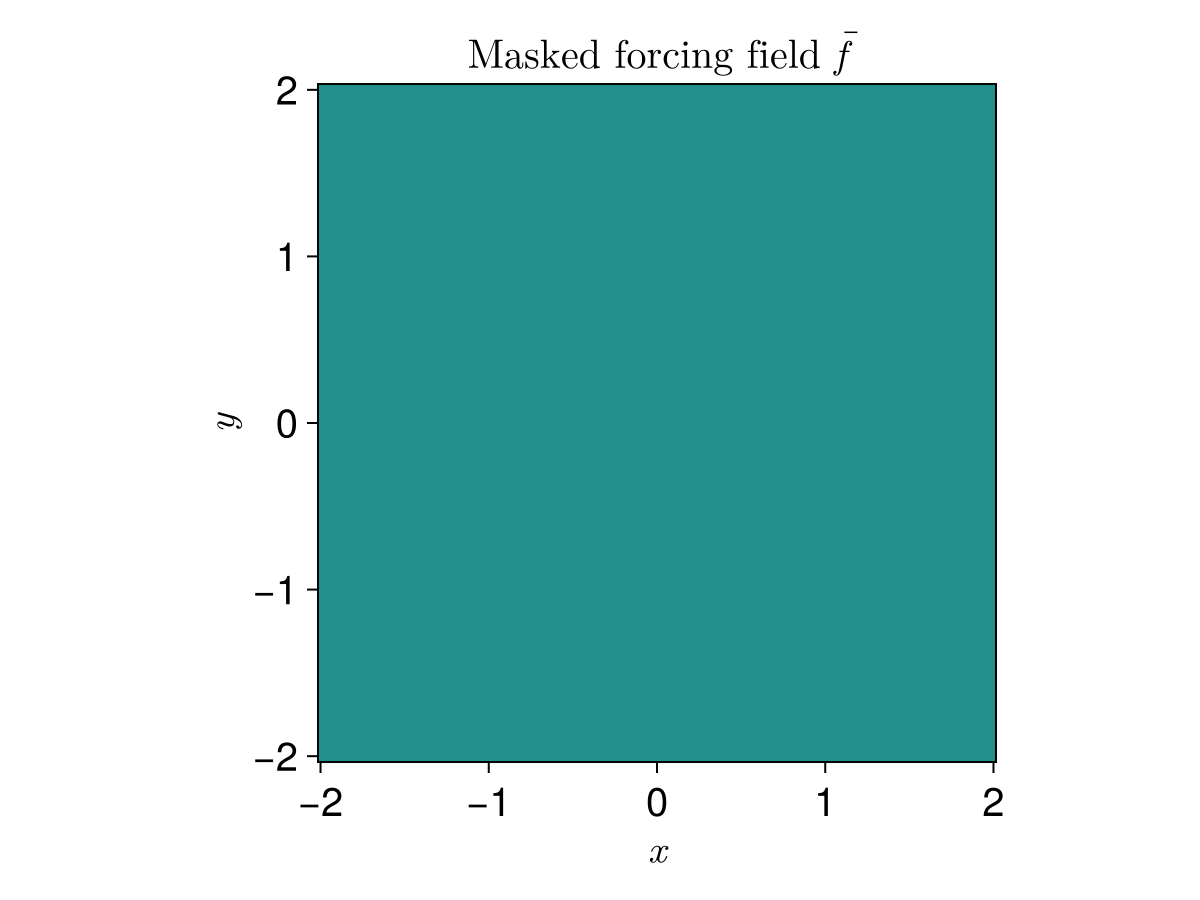

In [20]:
fig = Figure(fontsize = 20)

ax = Axis(fig[1,1], aspect = 1.0,
          xlabel = L"x", 
          ylabel = L"y", 
          title = L"\text{Masked forcing field } \overline{f}")

heatmap!(xgrid_primal, ygrid_primal, f̄_grid)

# lines!(ax, body.x, body.y, linewidth = 3)

fig

In [21]:
m = mask(cache);

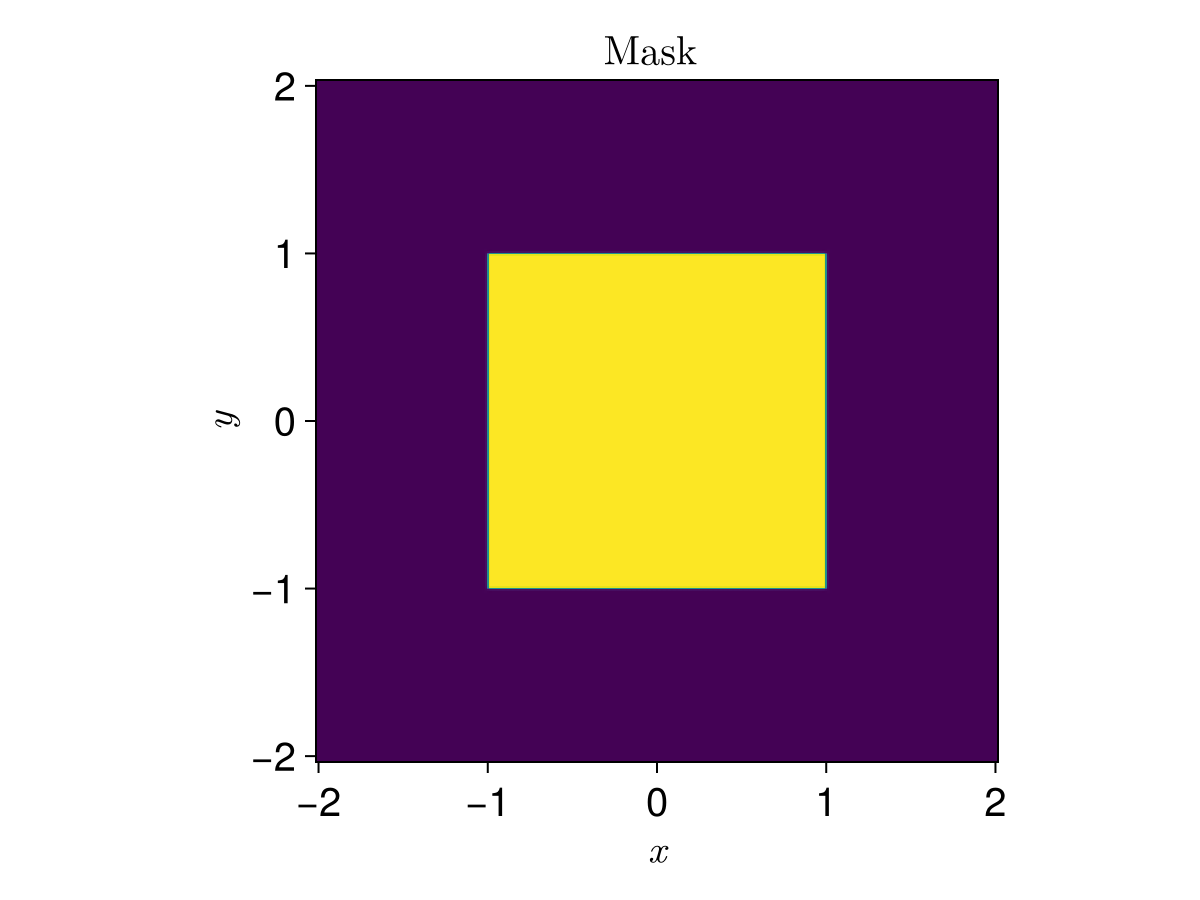

In [22]:
fig = Figure(fontsize = 20)

ax = Axis(fig[1,1], aspect = 1.0,
          xlabel = L"x", 
          ylabel = L"y", 
          title = L"\text{Mask }")

heatmap!(xgrid_primal, ygrid_primal, m)

fig

In [23]:
struct Darcy{NX, NY}
    κgrid::Edges{Primal, NX, NY}
    cache::Edges{Primal, NX, NY}
    dx::Float64
end

Darcy(κgrid::Edges{Primal, NX, NY}, dx::Float64) where {NX, NY} = Darcy(κgrid, zero(κgrid), dx)

function Darcy(κ̄::MaskedFunction, base_cache::BasicILMCache)
    κgrid = zeros_gridgrad(base_cache)
    cache = zeros_gridgrad(base_cache)
    
    xgridu, ygridu, xgridv, ygridv = coordinates(κgrid, base_cache.g)

    # Evaluate permeability field at primal edges
    for (i, xi) in enumerate(xgridu)
        for (j, yj) in enumerate(ygridu)
            κgrid.u[i,j] = κ̄(xi, yj)
        end
    end

    for (i, xi) in enumerate(xgridv)
        for (j, yj) in enumerate(ygridv)
            κgrid.v[i,j] = κ̄(xi, yj)
        end
    end
    NX, NY = base_cache.g.N
    
    return Darcy{NX, NY}(κgrid, cache, base_cache.g.Δx)
end

Base.eltype(Dop::Darcy{NX, NY}) where {NX, NY} = Float64

function darcy!(out::Nodes{Primal, NX, NY}, Dop::Darcy{NX, NY}, s::Nodes{Primal, NX, NY}) where {NX, NY}
    grad!(Dop.cache, s)
    Dop.cache .*= D.κgrid
    divergence!(out, Dop.cache)
    
    # Set boundaries to 0 to match with Laplace operator when κ(x,y) = 1
    out.data[1,:] .= 0
    out.data[end,:] .= 0
    out.data[:,1] .= 0
    out.data[:,end] .= 0
    return out
end

function darcy(Dop::Darcy{NX, NY}, s::Nodes{Primal, NX, NY}) where {NX, NY}
    darcy!(Nodes(Primal, s), Dop, s)
end

function mul!(out::Nodes{Primal, NX, NY}, Dop::Darcy{NX, NY}, s::Nodes{Primal, NX, NY}) where {NX, NY} 
    darcy!(out, Dop, s)
end

*(Dop::Darcy{NX,NY}, s::Nodes{Primal, NX, NY}) where {NX,NY} = darcy(Dop, s)

function (*)(Dop::Darcy{NX, NY}, s::Nodes{Primal, NX, NY}) where {NX, NY}
    mul!(Nodes(Primal, s), Dop, s)
end

* (generic function with 1016 methods)

In [24]:
# Define Darcy operator and the associated linear map
D = Darcy(κ̄, cache)
# Dop = ConstrainedSystems.linear_map(D,w)

Darcy{404, 408}(Primal edges for a (nx = 404, ny = 408) cell grid of type Float64 data
  Internal u-faces: (nx = 404, ny = 407)
  Internal v-faces: (nx = 403, ny = 408), Primal edges for a (nx = 404, ny = 408) cell grid of type Float64 data
  Internal u-faces: (nx = 404, ny = 407)
  Internal v-faces: (nx = 403, ny = 408), 0.01)

In [25]:
@testset "Test that Darcy operator reduces to Laplace operator when κ(x,y) = 1" begin
    w = zeros_grid(sys)
    w .= randn(size(w))
    norm_w = copy(norm(w))
    D = Darcy(MaskedFunction((x,y) -> 1.0, (x,y) -> 1.0, H), cache)
    result = D*w
    @test isapprox(result.data, laplacian(w).data, atol = 1e-8)
    @test isapprox(norm_w, norm(w), atol = 1e-8) 
end

Test Summary:                                                        | Pass  Total  Time
Test that Darcy operator reduces to Laplace operator when κ(x,y) = 1 |    2      2  0.8s


Test.DefaultTestSet("Test that Darcy operator reduces to Laplace operator when κ(x,y) = 1", Any[], 2, false, false, true, 1.711114974747657e9, 1.711114975516606e9, false, "In[25]")

Compute the term $\nabla \cdot((\kappa^+ \varphi_b^+ - \kappa^- \varphi_b^-) \delta(\chi) \mathbf{n})$

In [26]:
pts = points(cache)
Δκφb = zeros_surface(cache)

for i = 1:length(pts) ÷ 2
    xi = pts.u[i]
    yi = pts.v[i]
    Δκφb[i] = (κplus(xi, yi)*φplus(xi, yi) - κminus(xi, yi)*φminus(xi, yi))
end

div_κφb_grid = zeros_grid(cache)
surface_divergence!(div_κφb_grid, Δκφb, cache);

Form the top part of the right-hand-side $r_1 = \overline{f} + \nabla \cdot((\kappa^+ \varphi_b^+ - \kappa^- \varphi_b^-) \delta(\chi) \mathbf{n})$

In [27]:
# Form top part of right-hand side 
r1 = zeros_grid(cache)
r1 .= f̄_grid + div_κφb_grid;

Form the lower part of the right-hand-side $r_2 = \frac{1}{2}(\varphi_b^+ + \varphi_b^-)$

In [28]:
# Form lower part of right-hand side φb
r2 = zeros_surface(cache)

for i = 1:length(pts) ÷ 2
    xi = pts.u[i]
    yi = pts.v[i]
    r2[i] = 0.5*(φplus(xi, yi) +  φminus(xi, yi))
end

Build the right-hand-side of the saddle-point problem $\text{rhs} =[r_1, r_2]^\top$

In [29]:
# Build saddle-point problem
rhs = SaddleVector(r1, r2)

(Primal nodes in a (nx = 404, ny = 408) cell grid of type Float64 data
  Number of Primal nodes: (nx = 403, ny = 407), [-0.49624060150375937, -0.4887218045112782, -0.48120300751879697, -0.4736842105263158, -0.46616541353383456, -0.4586466165413534, -0.45112781954887216, -0.443609022556391, -0.43609022556390975, -0.4285714285714286  …  -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5])

In [30]:
# Build saddle system
φ̄_grid = zeros_grid(cache)
σ_surface = zeros_surface(cache)
sol = SaddleVector(φ̄_grid, σ_surface)

(Primal nodes in a (nx = 404, ny = 408) cell grid of type Float64 data
  Number of Primal nodes: (nx = 403, ny = 407), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

Sanity check with discrete Laplacian

In [31]:
sol_laplacian = zero(sol)

(Primal nodes in a (nx = 404, ny = 408) cell grid of type Float64 data
  Number of Primal nodes: (nx = 403, ny = 407), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [32]:
A_laplacian = SaddleSystem(cache.L,cache.E,cache.R,sol_laplacian)

Saddle system with 164021 states and 532 constraints and
   State vector of type Nodes{Primal, 404, 408, Float64, Matrix{Float64}}
   Constraint vector of type ScalarData{532, Float64, Vector{Float64}}
   Elements of type Float64
using a Direct solver


In [33]:
sol_laplacian .= A_laplacian\rhs

(Primal nodes in a (nx = 404, ny = 408) cell grid of type Float64 data
  Number of Primal nodes: (nx = 403, ny = 407), [-25.159190683676112, 30.504021775423272, -9.286655273636503, 4.030876730999046, -0.9037800743736762, 0.6678785376948118, 0.03082033288663437, 0.19879084770125177, 0.09943194082131586, 0.10770286055036024  …  -0.9343973467794585, -0.9340760644074827, -0.8513810508024583, -1.0181572986848266, -0.3934643672186766, -1.9908475281982467, 2.9732348930102996, -10.547179597696395, 29.665292165608044, -28.66298683801072])

In [34]:
norm(state(A_laplacian*sol_laplacian-rhs))

1.9441857292939422e-10

In [35]:
norm(constraint(A_laplacian*sol_laplacian-rhs))

7.745185618664852e-14

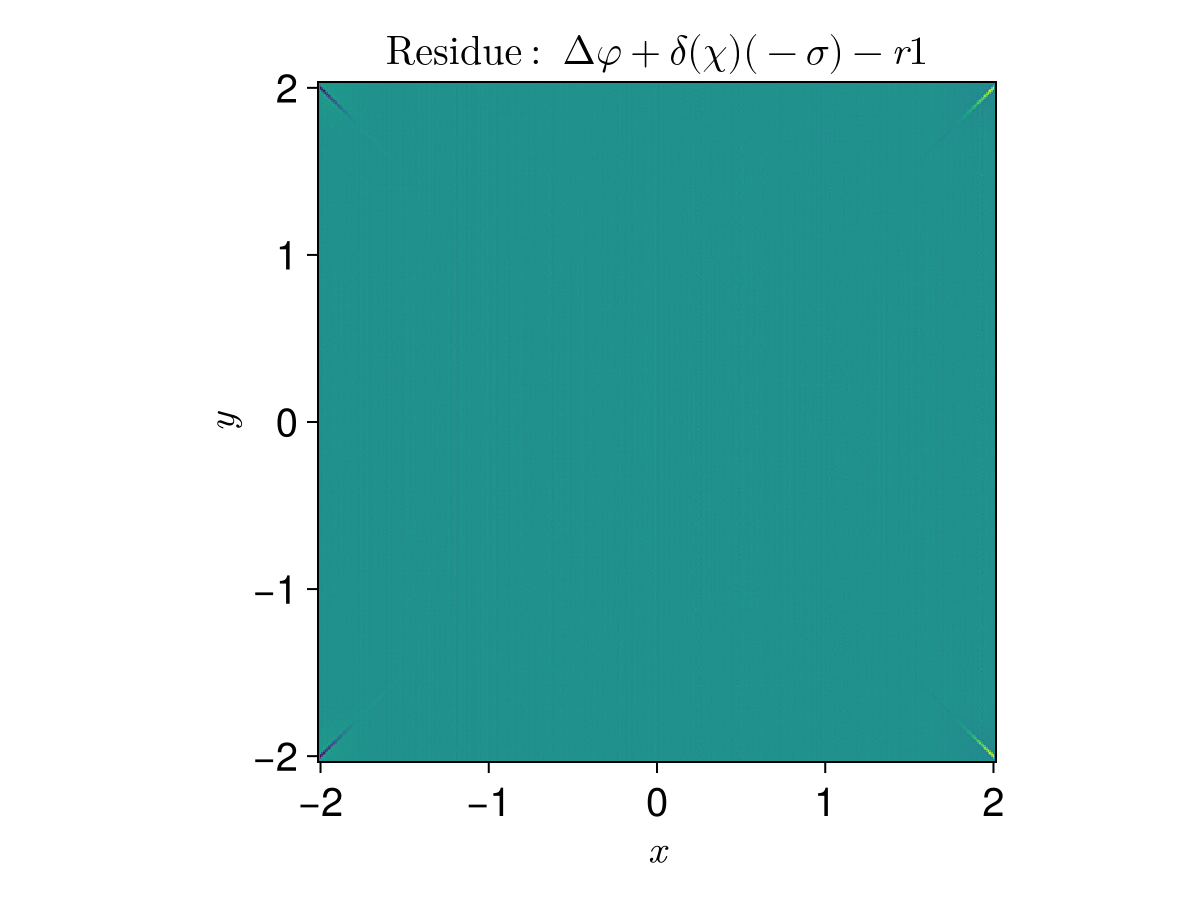

In [36]:
fig = Figure(fontsize = 20)

ax = Axis(fig[1,1], aspect = 1.0,
          xlabel = L"x", 
          ylabel = L"y", 
          title = L"\text{Residue: } \Delta \varphi + \delta(\chi)(-\sigma) - r1")

heatmap!(ax, xgrid_primal, ygrid_primal, cache.L*state(sol_laplacian) + cache.R*constraint(sol_laplacian) - r1)

# lines!(ax, body.x, body.y, linewidth = 3)

fig

Result is consistent with https://juliaibpm.github.io/ImmersedLayers.jl/dev/manual/dirichlet/

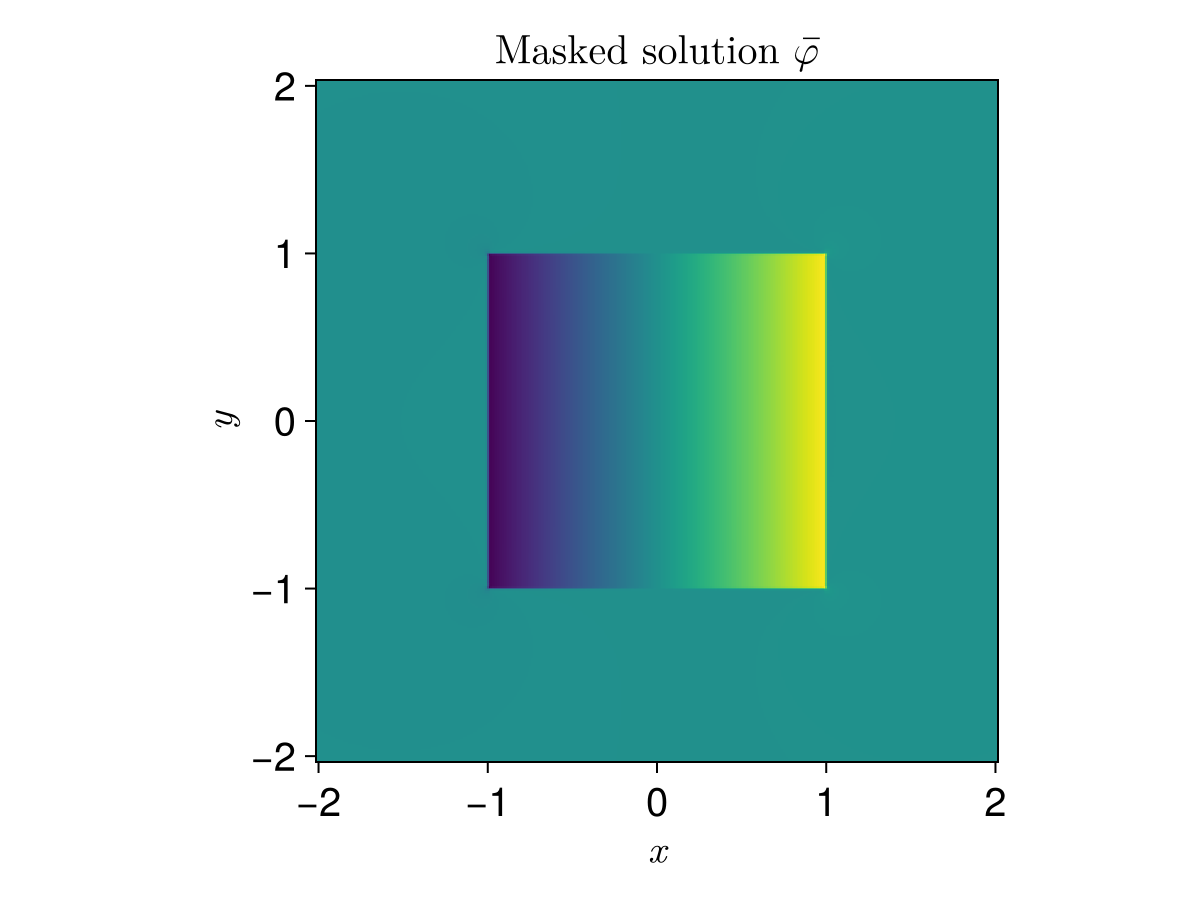

In [37]:
fig = Figure(fontsize = 20)

ax = Axis(fig[1,1], aspect = 1.0,
          xlabel = L"x", 
          ylabel = L"y", 
          title = L"\text{Masked solution } \overline{\varphi}")

heatmap!(ax, xgrid_primal, ygrid_primal, state(sol_laplacian))

# lines!(ax, body.x, body.y, linewidth = 3)

fig

In [38]:
# norm(state(sol_laplacian) - (a*b)/(2*π)^2*f̄_grid)

Use an iterative solver for the discrete Laplacian

## Define ldiv! operator for Darcy

Idea: define ldiv! using an iterative solver, 

ldiv!(x, D::Darcy, b) = IterativeSolvers.bicgstabl!(x, D, b)\
For this, we need to define a LinearMap wrapped around D. 

Not clear if that would work, as the operator discrete Laplacian cache.L has a null-space. 
Things don't seem to converge with the discrete Laplacian cache.L

In [65]:
# Create a random Primal Node matrix
w = zeros_grid(cache)
w.data .= randn(size(w));

In [66]:
Lop = ConstrainedSystems.linear_map(cache.L, zeros_grid(cache))

164021×164021 FunctionMap{Float64,false}(#48; issymmetric=false, ishermitian=false, isposdef=false)

In [67]:
Lop*zeros_grid(cache)

LoadError: DimensionMismatch: second dimension of left factor, 164021, does not match first dimension of right factor, 403

In [68]:
# Keeps running but doesn't converge
IterativeSolvers.gmres(Lop, w)

LoadError: InterruptException:

In [51]:
# Try to wrap cache.L into LinearMap

In [96]:
Lop = LinearMap{Float64}(x->cache.L*Nodes{Primal}(x), length(w))

164835×164835 FunctionMap{Float64,false}(#42; issymmetric=false, ishermitian=false, isposdef=false)

In [81]:
FunctionMap{Float64}(cache.L, length(w))

LoadError: BoundsError: attempt to access 0-element Vector{Method} at index [1]

In [82]:
?LinearMap

search: LinearMap LinearMaps linear_map SimpleNonlinearSolveTerminationMode



```
LinearMap(A::LinearMap; kwargs...)::WrappedMap
LinearMap(A::AbstractVecOrMatOrQ; kwargs...)::WrappedMap
LinearMap(J::UniformScaling, M::Int)::UniformScalingMap
LinearMap{T=Float64}(f, [fc,], M::Int, N::Int = M; kwargs...)::FunctionMap
LinearMap(A::MapOrVecOrMat, dims::Dims{2}, index::NTuple{2, AbstractVector{Int}})::EmbeddedMap
LinearMap(A::MapOrVecOrMat, dims::Dims{2}; offset::Dims{2})::EmbeddedMap
```

Construct a linear map object, either

1. from an existing `LinearMap` or `AbstractVecOrMat`/`AbstractQ` `A`, with the purpose of

redefining its properties via the keyword arguments `kwargs`, see below;

2. a `UniformScaling` object `J` with specified (square) dimension `M`;
3. from a function or callable object `f`;
4. from an existing `LinearMap` or `AbstractVecOrMat`/`AbstractQ` `A`, embedded in a larger zero map.

In the case of item 3, one also needs to specify the size of the equivalent matrix representation `(M, N)`, i.e., for functions `f` acting on length `N` vectors and producing length `M` vectors (with default value `N=M`). Preferably, also the `eltype` `T` of the corresponding matrix representation needs to be specified, i.e., whether the action of `f` on a vector will be similar to, e.g., multiplying by numbers of type `T`. If not specified, the default value `T=Float64` will be assumed. Optionally, a corresponding function `fc` can be specified that implements the adjoint (or transpose in the real case) of `f`.

The keyword arguments and their default values are:

  * `issymmetric::Bool = false` : whether `A` or `f` act as a symmetric matrix
  * `ishermitian::Bool = issymmetric & T<:Real` : whether `A` or `f` act as a Hermitian matrix
  * `isposdef::Bool = false` : whether `A` or `f` act as a positive definite matrix.

For existing linear maps or matrices `A`, the default values will be taken by calling internal functions `_issymmetric`, `_ishermitian` and `_isposdef` on the existing object `A`. These in turn dispatch to (overloads of) `LinearAlgebra`'s `issymmetric`, `ishermitian`, and `isposdef` methods whenever these checks are expected to be computationally cheap or even known at compile time as for certain structured matrices, but return `false` for generic `AbstractMatrix` types.

For the function-based constructor, there is one more keyword argument:

  * `ismutating::Bool` : flags whether the function acts as a mutating matrix multiplication `f(y,x)` where the result vector `y` is the first argument (in case of `true`), or as a normal matrix multiplication that is called as `y=f(x)` (in case of `false`). The default value is guessed by looking at the number of arguments of the first occurrence of `f` in the method table.

For the `EmbeddedMap` constructors, `dims` specifies the total dimensions of the map. The `index` argument specifies two collections of indices `inds1` and `inds2`, such that for the big zero map `L` (thought of as a matrix), one has `L[inds1,inds2] == A`. In other words, `inds1` specifies the output indices, `inds2` specifies the input indices. Alternatively, `A` may be shifted by `offset`, such that (thinking in terms of matrices again) `L[offset[1] .+ axes(A, 1), offset[2] .+ axes(A, 2)] == A`.


In [76]:
?FunctionMap

search: FunctionMap Function function functionloc FunctionProfile



```
FunctionMap{T,iip}(f, [fc,], M, N = M; kwargs...)
```

Construct a `FunctionMap` object from a function or callable object `f` that represents a linear map of size `(M, N)`, where `N` can be omitted for square operators of size `(M,M)`. Furthermore, the `eltype` `T` of the corresponding matrix representation needs to be specified, i.e., whether the action of `f` on a vector will be similar to, e.g., multiplying by numbers of type `T`. Optionally, a second function `fc` can be specified that implements the adjoint (or transpose in the real case) of `f`.

Accepted keyword arguments and their default values are as in the [`LinearMap`](@ref) constructor.

# Examples

```jldoctest julia> F = FunctionMap{Int64,false}(cumsum, 2) 2×2 FunctionMap{Int64,false}(cumsum; issymmetric=false, ishermitian=false, isposdef=false)

julia> F * ones(Int64, 2) 2-element Vector{Int64}:  1  2

julia> Matrix(F) 2×2 Matrix{Int64}:  1  0  1  1


In [74]:
LinearMap{Float64}(cache.L, w)

LoadError: MethodError: no method matching (FunctionMap{Float64})(::Laplacian{408, 406, Float64, true, false}, ::Nodes{Primal, 408, 406, Float64, Matrix{Float64}})

[0mClosest candidates are:
[0m  (FunctionMap{T})(::Any, ::Any, [91m::Int64[39m, [91m::Int64[39m; ismutating, kwargs...) where T
[0m[90m   @[39m [33mLinearMaps[39m [90m~/.julia/packages/LinearMaps/AWz3y/src/[39m[90m[4mfunctionmap.jl:52[24m[39m
[0m  (FunctionMap{T})(::Any, ::Any, [91m::Int64[39m; ismutating, kwargs...) where T
[0m[90m   @[39m [33mLinearMaps[39m [90m~/.julia/packages/LinearMaps/AWz3y/src/[39m[90m[4mfunctionmap.jl:58[24m[39m
[0m  (FunctionMap{T})(::Any, [91m::Int64[39m; ismutating, kwargs...) where T
[0m[90m   @[39m [33mLinearMaps[39m [90m~/.julia/packages/LinearMaps/AWz3y/src/[39m[90m[4mfunctionmap.jl:54[24m[39m
[0m  ...


In [66]:
LinearMap{Float64}(x->D*x, w)

LoadError: MethodError: no method matching (FunctionMap{Float64})(::var"#24#25", ::Nodes{Primal, 408, 406, Float64, Matrix{Float64}})

[0mClosest candidates are:
[0m  (FunctionMap{T})(::Any, ::Any, [91m::Int64[39m, [91m::Int64[39m; ismutating, kwargs...) where T
[0m[90m   @[39m [33mLinearMaps[39m [90m~/.julia/packages/LinearMaps/AWz3y/src/[39m[90m[4mfunctionmap.jl:52[24m[39m
[0m  (FunctionMap{T})(::Any, ::Any, [91m::Int64[39m; ismutating, kwargs...) where T
[0m[90m   @[39m [33mLinearMaps[39m [90m~/.julia/packages/LinearMaps/AWz3y/src/[39m[90m[4mfunctionmap.jl:58[24m[39m
[0m  (FunctionMap{T})(::Any, [91m::Int64[39m; ismutating, kwargs...) where T
[0m[90m   @[39m [33mLinearMaps[39m [90m~/.julia/packages/LinearMaps/AWz3y/src/[39m[90m[4mfunctionmap.jl:54[24m[39m
[0m  ...


In [60]:
w = zeros_grid(cache)
w.data .= randn(size(w.data))

407×405 Matrix{Float64}:
  0.0606826  -0.37313     0.469164   …  -1.32338    -0.468007   -1.60588
 -0.218406    1.47871    -0.464162       0.374805    0.828614   -0.873763
 -0.0218561   1.0631      1.63309       -1.34245    -0.763532    0.633661
  0.856533   -1.97759    -1.35437        0.492255   -0.572881   -0.218798
  1.6106     -1.16702    -1.30298       -0.297716   -1.05665    -0.797967
  0.802503   -0.583765    0.0623898  …  -0.113113    0.149189   -1.29238
  1.05741    -0.180779    0.615874      -1.25849     0.375443   -0.444587
 -1.29234    -0.122874   -0.952479      -1.45798     1.32687     0.738545
  0.202       1.2835      1.15323       -1.36717    -0.162956   -2.48347
 -1.52145     0.472579    0.141028      -1.83676    -1.82766    -0.388664
 -0.182012    1.74794    -0.838818   …   1.05994    -0.509647    0.707935
 -1.91823    -1.36071     0.897208       0.036798    1.65135    -2.33295
  0.0948206   0.056344   -0.877333      -1.55728     1.3013      0.133337
  ⋮              

In [52]:
IterativeSolvers.bicgstabl(cache.L, w)

LoadError: MethodError: no method matching size(::Laplacian{404, 408, Float64, true, false}, ::Int64)

[0mClosest candidates are:
[0m  size([91m::Makie.TextureAtlas[39m, ::Any)
[0m[90m   @[39m [32mMakie[39m [90m~/.julia/packages/Makie/VRavR/src/utilities/[39m[90m[4mtexture_atlas.jl:30[24m[39m
[0m  size([91m::Scene[39m, ::Any)
[0m[90m   @[39m [32mMakie[39m [90m~/.julia/packages/Makie/VRavR/src/[39m[90m[4mscenes.jl:345[24m[39m
[0m  size([91m::BitVector[39m, ::Integer)
[0m[90m   @[39m [90mBase[39m [90m[4mbitarray.jl:107[24m[39m
[0m  ...
